# Imputation model to predict species (Decision tree)

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# for vizualizing DT
from sklearn.tree import export_graphviz 
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
df = pd.read_csv("../imputation_model/raw_data/field_genetics_species.csv")
df.head()

,date,watershed,river,site,method,local,water_temp_start,fork_length_mm,annoted_species,confirmed_species,tag_id_long
0,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,coho,989.001038864826
1,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864862
2,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864891
3,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864827
4,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864865


In [3]:
df.isnull().sum()

date                  0
watershed             0
river                 0
site                  0
method                0
local                 0
water_temp_start     26
fork_length_mm       13
annoted_species       1
confirmed_species     0
tag_id_long          64
dtype: int64

In [4]:
df.annoted_species.unique()

array(['ck', 'co', 'rbt', nan], dtype=object)

In [5]:
df.confirmed_species.unique()

array(['coho', 'chinook', 'steelhead'], dtype=object)

In [6]:
for col in df.columns:
    if col not in ['tag_id_long', 'water_temp_start', 'fork_length_mm']:
        print(col, ":", df[col].unique())

date : ['2021-06-02' '2021-06-04' '2021-06-08' '2021-06-09' '2021-06-10'
 '2021-06-14' '2021-06-16' '2021-06-23' '2021-06-24' '2022-05-30'
 '2022-06-01' '2022-06-06' '2022-06-08' '2022-06-13' '2022-06-15'
 '2022-06-17' '2022-06-22' '2022-06-20' '2022-06-27' '2023-05-31'
 '2022-05-26' '2021-06-11' '2021-06-07' '2021-06-18' '2022-06-23'
 '2021-06-22' '2022-06-21' '2022-06-16' '2022-06-30' '2022-05-25']
watershed : ['puntledge' 'nanaimo']
river : ['puntledge' 'nanaimo']
site : ['above tsolum' 'condensory bridge' 'tsolum confluence' 'little mexico'
 'jack point' 'living forest' 'cedar bridge' 'newcastle'
 'snuneymuxw beach']
method : ['beach seine']
local : ['in-river' 'marine']
annoted_species : ['ck' 'co' 'rbt' nan]
confirmed_species : ['coho' 'chinook' 'steelhead']


In [7]:
df_clean = df.drop(['tag_id_long', 'water_temp_start'], axis = 1)
df_clean = df_clean.dropna()

In [8]:
df_clean.isnull().sum()

date                 0
watershed            0
river                0
site                 0
method               0
local                0
fork_length_mm       0
annoted_species      0
confirmed_species    0
dtype: int64

In [9]:
df_clean["confirmed_species"].value_counts()

confirmed_species
chinook      4695
coho          297
steelhead       8
Name: count, dtype: int64

In [10]:
df_sampled = df_clean[df_clean['confirmed_species'] == 'chinook'].sample(n=300, random_state=42)
others_combined = df_clean[df_clean['confirmed_species'].isin(["coho", "steelhead"])]
df_sampled = pd.concat([df_sampled, others_combined], axis=0)
df_sampled = df_sampled.reset_index(drop=True)


In [11]:
df_sampled["confirmed_species"].value_counts()

confirmed_species
chinook      300
coho         297
steelhead      8
Name: count, dtype: int64

In [12]:
df_sampled

,date,watershed,river,site,method,local,fork_length_mm,annoted_species,confirmed_species
0,2022-06-17,puntledge,puntledge,little mexico,beach seine,marine,93.0,ck,chinook
1,2022-06-06,nanaimo,nanaimo,jack point,beach seine,marine,69.0,ck,chinook
2,2021-06-07,nanaimo,nanaimo,jack point,beach seine,marine,79.0,ck,chinook
3,2022-06-01,nanaimo,nanaimo,jack point,beach seine,marine,62.0,ck,chinook
4,2021-06-11,nanaimo,nanaimo,cedar bridge,beach seine,in-river,89.0,ck,chinook
...,...,...,...,...,...,...,...,...,...
600,2021-06-14,puntledge,puntledge,little mexico,beach seine,marine,118.0,ck,coho
601,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,92.0,rbt,steelhead
602,2021-06-14,puntledge,puntledge,little mexico,beach seine,marine,118.0,ck,coho
603,2021-06-14,puntledge,puntledge,little mexico,beach seine,marine,127.0,ck,coho


## Pipeline 

### Pre-processing for the model

In [13]:
X = df_sampled.drop(['confirmed_species', 'annoted_species'], axis = 1)
y = df_sampled['confirmed_species']

In [14]:
X["year"] = pd.DatetimeIndex(X['date']).year
X['day_of_year'] = pd.to_datetime(X['date']).dt.dayofyear
X.head()

,date,watershed,river,site,method,local,fork_length_mm,year,day_of_year
0,2022-06-17,puntledge,puntledge,little mexico,beach seine,marine,93.0,2022,168
1,2022-06-06,nanaimo,nanaimo,jack point,beach seine,marine,69.0,2022,157
2,2021-06-07,nanaimo,nanaimo,jack point,beach seine,marine,79.0,2021,158
3,2022-06-01,nanaimo,nanaimo,jack point,beach seine,marine,62.0,2022,152
4,2021-06-11,nanaimo,nanaimo,cedar bridge,beach seine,in-river,89.0,2021,162


In [15]:
# numeric_feats = [""]  # apply scaling
categorical_feats = ["watershed", "river", "site", "method", "local", "year"]  # apply one-hot encoding
passthrough_feats = ["fork_length_mm", "day_of_year"]  # do not apply any transformation
drop_feats = [ "date" ]  
# levels = ["", ""]

In [16]:
ct = make_column_transformer (    
    #(StandardScaler(), numeric_feats),  
    ("passthrough", passthrough_feats),     
    (OneHotEncoder(), categorical_feats),  
    ("drop", drop_feats), 
    #OrdinalEncoder(categories=[levels], dtype=int)
)

In [17]:
transformed = ct.fit_transform(X)

In [18]:
column_names = (
    # numeric_feats
    passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['fork_length_mm',
 'day_of_year',
 'watershed_nanaimo',
 'watershed_puntledge',
 'river_nanaimo',
 'river_puntledge',
 'site_above tsolum',
 'site_cedar bridge',
 'site_condensory bridge',
 'site_jack point',
 'site_little mexico',
 'site_living forest',
 'site_newcastle',
 'site_snuneymuxw beach',
 'site_tsolum confluence',
 'method_beach seine',
 'local_in-river',
 'local_marine',
 'year_2021',
 'year_2022',
 'year_2023']

In [19]:
X_transformed = pd.DataFrame(transformed, columns=column_names)
X_transformed.head()

,fork_length_mm,day_of_year,watershed_nanaimo,watershed_puntledge,river_nanaimo,river_puntledge,site_above tsolum,site_cedar bridge,site_condensory bridge,site_jack point,...,site_living forest,site_newcastle,site_snuneymuxw beach,site_tsolum confluence,method_beach seine,local_in-river,local_marine,year_2021,year_2022,year_2023
0,93.0,168.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,69.0,157.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,79.0,158.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,62.0,152.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,89.0,162.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


### Dummy model (Baseline)

In [20]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_transformed, y)
dummy_clf.score(X_transformed, y)

0.49586776859504134

### Decision Tree

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'max_depth': randint(1, 10), #Change to 20 when the dataset is bigger, 20 overfits currently
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(DecisionTreeClassifier(), 
                                   param_distributions=param_dist, 
                                   n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Best parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Score:  0.9173754295532646


In [23]:
decision_tree = DecisionTreeClassifier(
    max_depth = random_search.best_params_["max_depth"],
    min_samples_split = random_search.best_params_["min_samples_split"],
    min_samples_leaf = random_search.best_params_["min_samples_leaf"],
    random_state = 42)

decision_tree.fit(X_train, y_train)
print("Train accuracy:", decision_tree.score(X_train, y_train))

Train accuracy: 0.9483471074380165


In [24]:
decision_tree

DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=42)

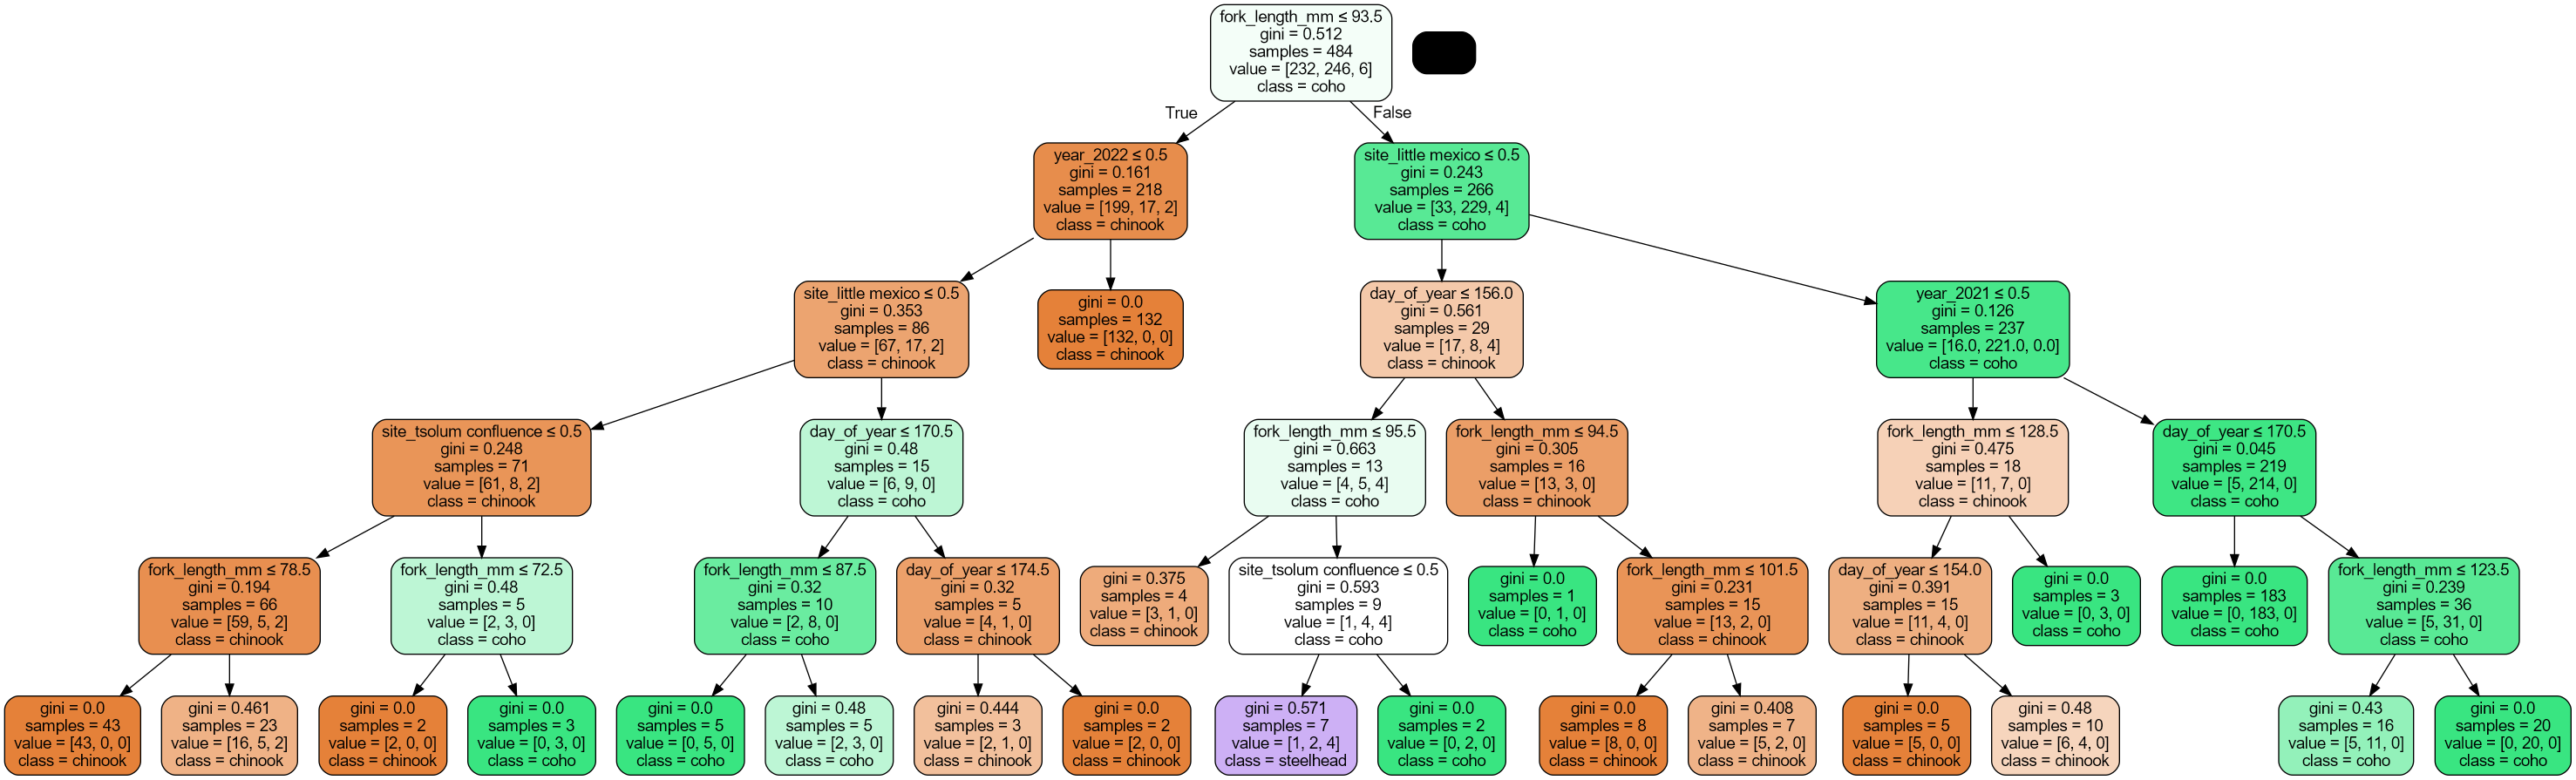

In [26]:
dot_data = StringIO()
export_graphviz(decision_tree, out_file = dot_data, filled = True, 
                rounded = True, 
                special_characters = True,
                feature_names = column_names,
                class_names = ["chinook", "coho", "steelhead"], max_depth = 7)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("Decision_tree.png")
Image(graph.create_png())

In [27]:
print("Test score: ", decision_tree.score(X_test, y_test))

Test score:  0.9421487603305785


In [28]:
y_pred = decision_tree.predict(X_test)

In [29]:
# Predictions on validation set (taken from the train set)
y_pred[:5]

array(['coho', 'chinook', 'chinook', 'chinook', 'chinook'], dtype=object)

Now lets test this model on our data:

1. Cant violate golden rule
2. test it on the data
    1. lab v/s model prediction
    2. lab v/s tagged species